In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.gravity_processing as grav
import RIS_gravity_inversion.uncertainties as uncert

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import plotly.figure_factory as ff
import seaborn as sns

sns.set_theme()
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle
import random

import os

In [17]:
plot = True
# plot = False
runs = 20

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    "../../inversion_layers/Ross_Sea_starting_prisms.zarr",
)

# partial bouguer corrected gravity data
df_anomalies = pd.read_csv(
    "../../synthetic_data/Ross_Sea_gravity_anomalies_survey_noise.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
).rename(columns={"bed_forward":"starting_bed_grav"})
# df_anomalies = df_anomalies[df_anomalies.test == False]

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]
layer_spacing = 5e3

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)


# get real bed model
bed = xr.open_zarr("../../synthetic_data/Ross_Sea_bed.zarr").z.rename("upward")

# constraints
constraints = pd.read_csv(
    "../../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
).rename(columns={"uncert":"z_error"})

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
constraints["weights"] = 1 / (constraints.z_error**2)

# # subset buffer zone points
# buffer_constraints = utils.points_inside_region(
#     constraints, inversion_region, reverse=True, names=("easting", "northing")
# )
# buffer_constraints["buffer"] = True
# buffer_constraints["inside"] = False

# # subset inversion zone points
# inv_constraints = utils.points_inside_region(
#     constraints, inversion_region, names=("easting", "northing")
# )
# inv_constraints["buffer"] = False

# # merge inversion and buffer points
# constraints = pd.concat([buffer_constraints, inv_constraints])

# print(f"Total constraints:{len(constraints)}")
# print(f"Buffer constraints:{len(constraints[constraints.buffer])}")
# print(f"Inside ice shelf constraints:{len(constraints[constraints.inside])}")

layer spacing: 5000.0m
registration: g
inversion region =  (-40000.0, 260000.0, -1800000.0, -1400000.0)
buffer region =  [-80000.0, 300000.0, -1840000.0, -1360000.0]


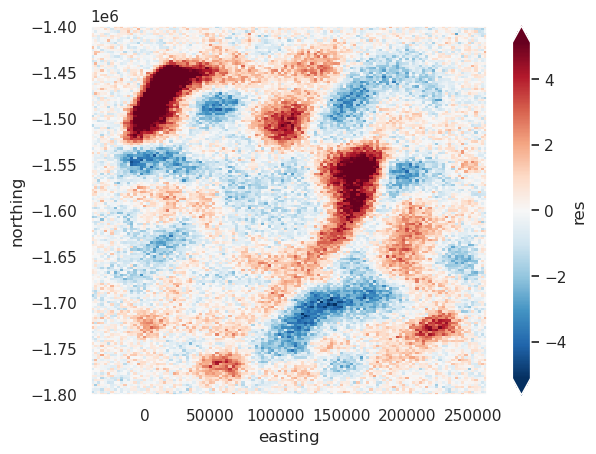

In [4]:
df_anomalies.set_index(["northing", "easting"]).to_xarray().res.plot(robust=True)

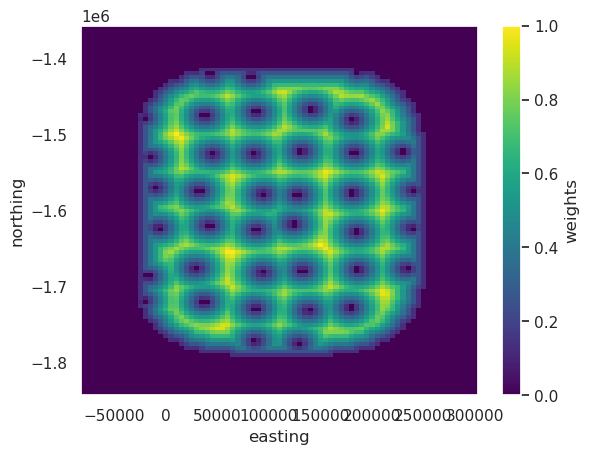

In [5]:
weights_grid = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    region=inversion_region,
)
starting_prisms["weights"] = weights_grid
starting_prisms.weights.plot()

# Add uncertainties 
2% of max absolute values for gravity data

10% depth from ice surface for constraints within ice shelf

In [6]:
print(
    f"mean uncertainty inside RIS: {np.nanmean(constraints[constraints.inside].z_error)} m"
)
print(
    f"mean uncertainty outside RIS: {np.nanmean(constraints[constraints.inside==False].z_error)} m"
)

constraints.describe()

mean uncertainty inside RIS: 9.098066280714873 m
mean uncertainty outside RIS: 5.0 m


,northing,easting,upward,z_error,weights
count,3.542000e+03,3542.000000,3542.000000,3542.000000,3542.000000
mean,-1.598879e+06,108292.121820,-550.694628,5.045123,0.039723
std,1.713490e+05,139451.979414,144.422261,0.486578,0.002768
min,-1.840000e+06,-80000.000000,-969.619486,5.000000,0.006106
25%,-1.780000e+06,-35000.000000,-643.893550,5.000000,0.040000
50%,-1.597500e+06,105000.000000,-551.693350,5.000000,0.040000
75%,-1.415000e+06,255000.000000,-443.250754,5.000000,0.040000
max,-1.360000e+06,300000.000000,-164.541535,12.797503,0.040000


In [7]:
# 2% of max absolute value
maxabs = np.max(np.abs(df_anomalies.Gobs))*.02
print(f"Max absolute value of gravity: {maxabs} mGal")
df_anomalies["uncert"] = maxabs
df_anomalies

Max absolute value of gravity: 0.6123442063786252 mGal


,northing,easting,Gobs,test,upward,starting_bed_grav,Gobs_shift,misfit,reg,res,uncert
0,-1800000.0,-40000.0,14.287668,False,1000.0,1.588803,8.532919,6.944116,6.648925,0.295191,0.612344
1,-1800000.0,-37500.0,14.072045,True,1000.0,2.189981,8.317296,6.127315,6.677394,-0.550080,0.612344
2,-1800000.0,-35000.0,15.014290,False,1000.0,2.731633,9.259541,6.527907,6.685311,-0.157404,0.612344
3,-1800000.0,-32500.0,16.312788,True,1000.0,3.225948,10.558038,7.332090,6.639794,0.692296,0.612344
4,-1800000.0,-30000.0,16.553617,False,1000.0,3.687668,10.798868,7.111200,6.557271,0.553928,0.612344
...,...,...,...,...,...,...,...,...,...,...,...
19476,-1400000.0,250000.0,-20.592654,False,1000.0,-16.379783,-26.347404,-9.967621,-9.599613,-0.368008,0.612344
19477,-1400000.0,252500.0,-20.919847,True,1000.0,-16.835889,-26.674596,-9.838707,-10.226815,0.388108,0.612344
19478,-1400000.0,255000.0,-22.264334,False,1000.0,-17.321311,-28.019084,-10.697772,-10.656040,-0.041732,0.612344
19479,-1400000.0,257500.0,-22.746881,True,1000.0,-17.722308,-28.501630,-10.779322,-10.773961,-0.005361,0.612344


# Setup Monte-Carlo sampling
* define sampling methods for the uncertainties of both the gravity and constraints data
* run full inversion with sampled gravity
    * including: 
        * corrections for parital bouguer and starting bed
        * DC shift
        * regional / residual seperation
        * inversion
* find standard deviation per grid cell of all resulting inverted bathymetry models

## Run inversion workflow

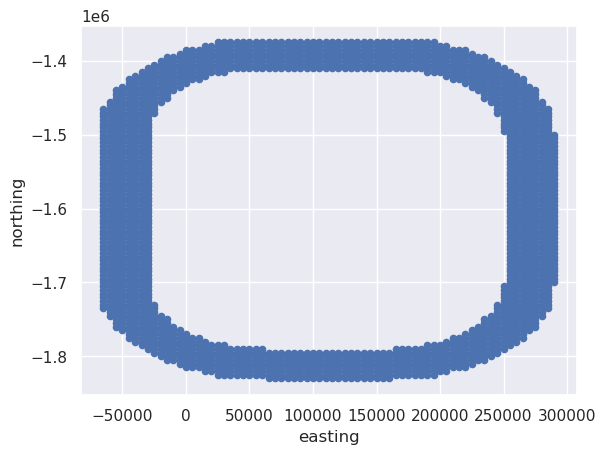

In [8]:
# get ice shelf mask
mask = gpd.read_file("../../data/Ross_Sea_outline.shp")
mask = mask.dissolve()

# get points within ice shelf border and buffered border
buffer_points, _, bed_outside = inv_utils.get_buffer_points(
    buffer_width=40e3,
    grid=bed,
    mask=mask,
    plot = True,
)

In [9]:
# bed_from_constraints = inv_utils.recreate_bed(
#     inside_points = constraints[constraints.inside],
#     buffer_points = buffer_points,
#     outside_grid = bed_outside,
#     region = buffer_region,
#     layer_spacing = layer_spacing,
#     outside_error = 5, 
    
#     method = "spline",
#     damping = 10e-20,

#     # method = "surface",
#     # tension = 0,

# )

In [10]:
# output = bed_from_constraints.to_dataset(name="z")
# output.to_zarr(
#     "../../synthetic_data/Ross_Sea_starting_bed.zarr",
#     encoding={"z": {"compressor": zarr.Blosc()}},
#     mode="w",
# )

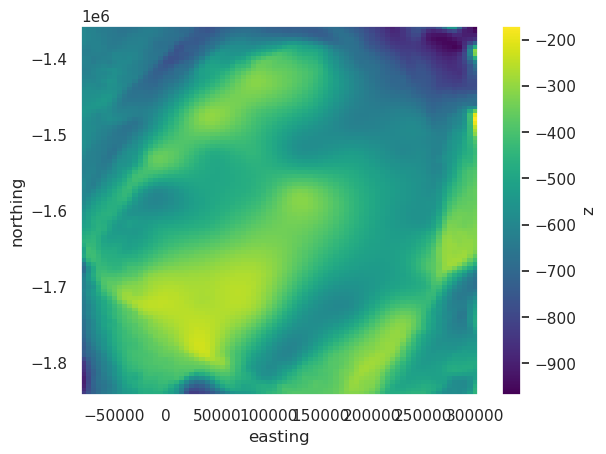

In [11]:
bed_from_constraints = xr.open_zarr("../../synthetic_data/Ross_Sea_starting_bed.zarr").z
bed_from_constraints.plot()

In [12]:
kwargs = dict(
    grav_spacing=layer_spacing,
    inversion_region=inversion_region,
    buffer_region=buffer_region,
    layer_spacing=layer_spacing,
    # optional:
    weights_grid=weights_grid,
    starting_bed_prisms=starting_prisms,
    starting_bed=bed_from_constraints,
    solver_damping=10**-2,
    # recreate bed kwargs:
    buffer_points=buffer_points,
    bed_outside=bed_outside,
    # damping CV kwargs:
    CV_damping_values=np.logspace(-4, -1, 6),
    # CV_damping_values = np.logspace(-4, -2, 1),
)

inversion_args = dict(
    input_grav_column="Gobs_shift",
    apply_weights=False,
    weights_after_solving=True,
    max_iterations=50,
    l2_norm_tolerance=0.15,
    delta_l2_norm_tolerance=1.02,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

starting_args = dict(
    density_contrast=1276, # 2300 - 1024
    regional_tension_factor=0.5,
    regional_damping=1.3894954943731388e-08,
    regional_grid_method="verde",
    starting_bed_tension=0.5,
    starting_bed_damping=10**-20,
    starting_bed_method="spline",
)

## Full (gravity, constraints, density)

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

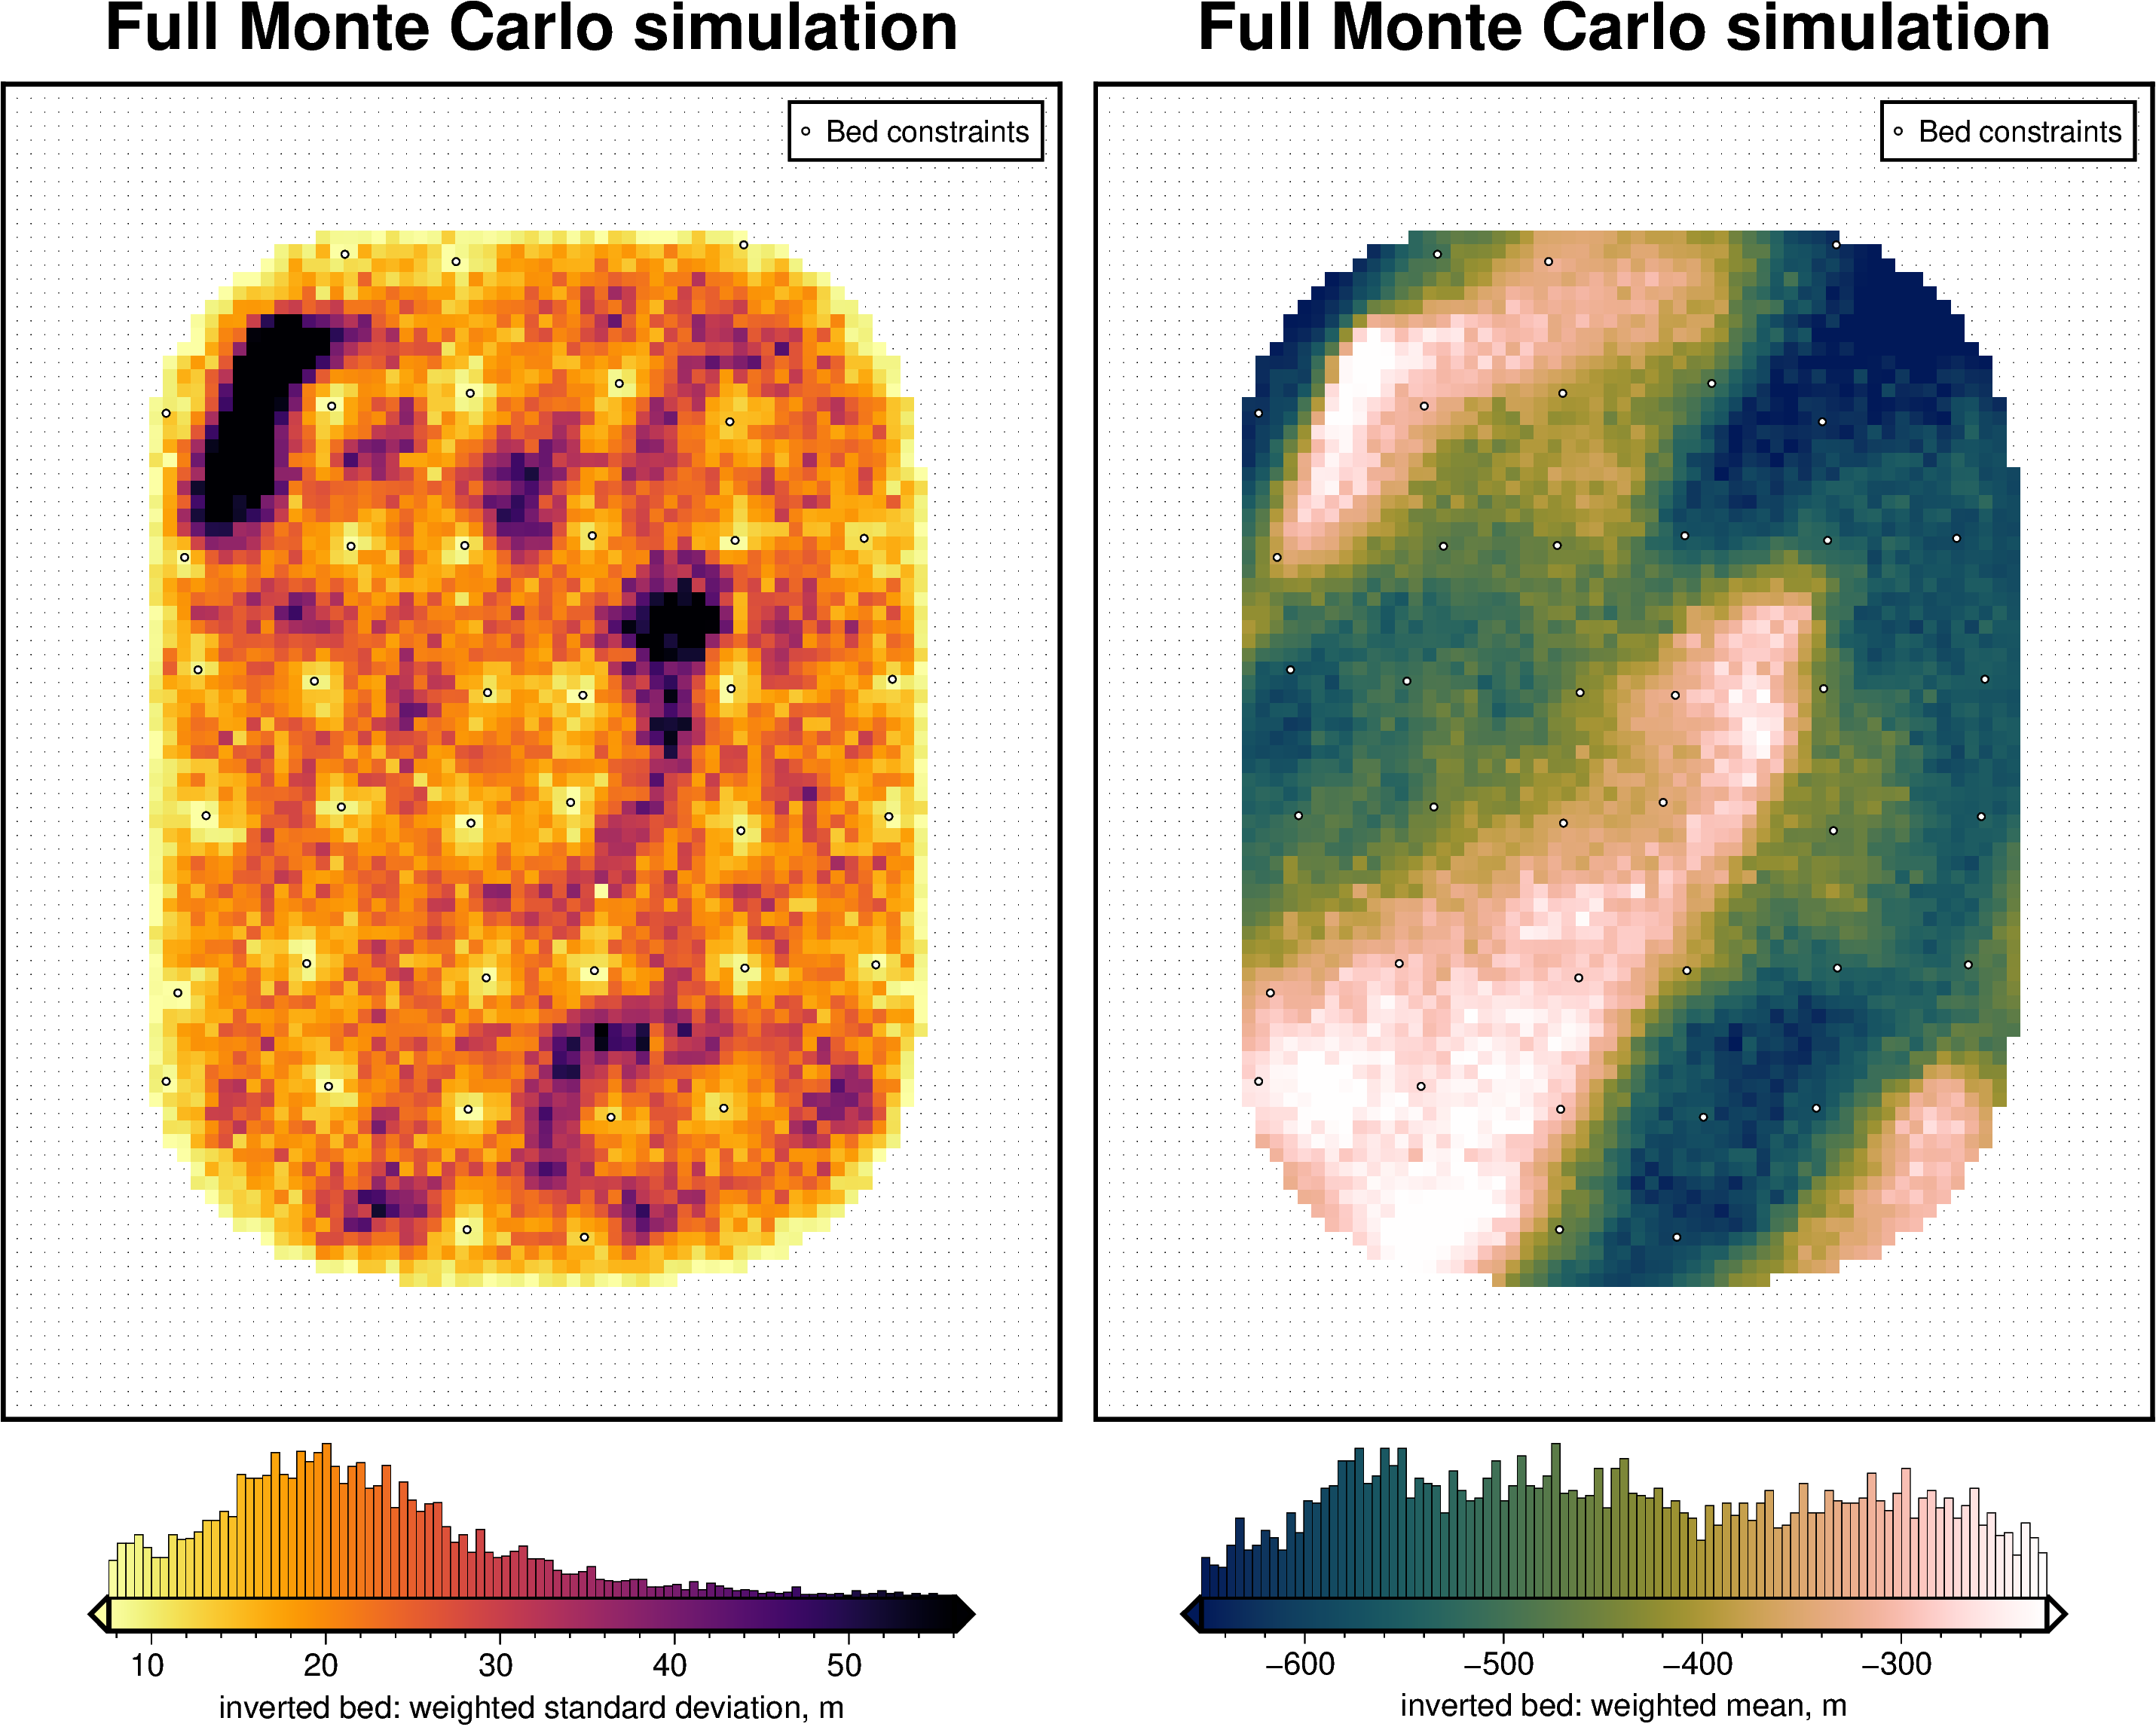

In [13]:
path = "../../synthetic_data/monte_carlo_results/"
prefix = "Ross_Sea_monte_carlo_full"
fname = path + prefix

full_surface_results = uncert.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,

    sample_grav=True,  # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    sample_density_contrast=True,  # will recalculate bed gravity and regional field

    run_damping_CV = True,
    damping_CV_fname = path+"damping_CV_results/"+prefix,

    inversion_args=inversion_args,
    starting_args=starting_args,
    sampling="LHC",
    **kwargs,
)

params, values, grav_dfs, prism_dfs = full_surface_results

# ds = uncert.merged_stats(
#     full_surface_results,
#     "topo",
#     "starting_bed",
#     plot=plot,
#     mask="../../plotting/RIS_outline.shp",
#     title="Full Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
ds = uncert.merged_stats(
    full_surface_results,
    "topo",
    -1,
    plot=plot,
    # plot=False,
    mask="../../data/Ross_Sea_outline.shp",
    title="Full Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)

## Gravity

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

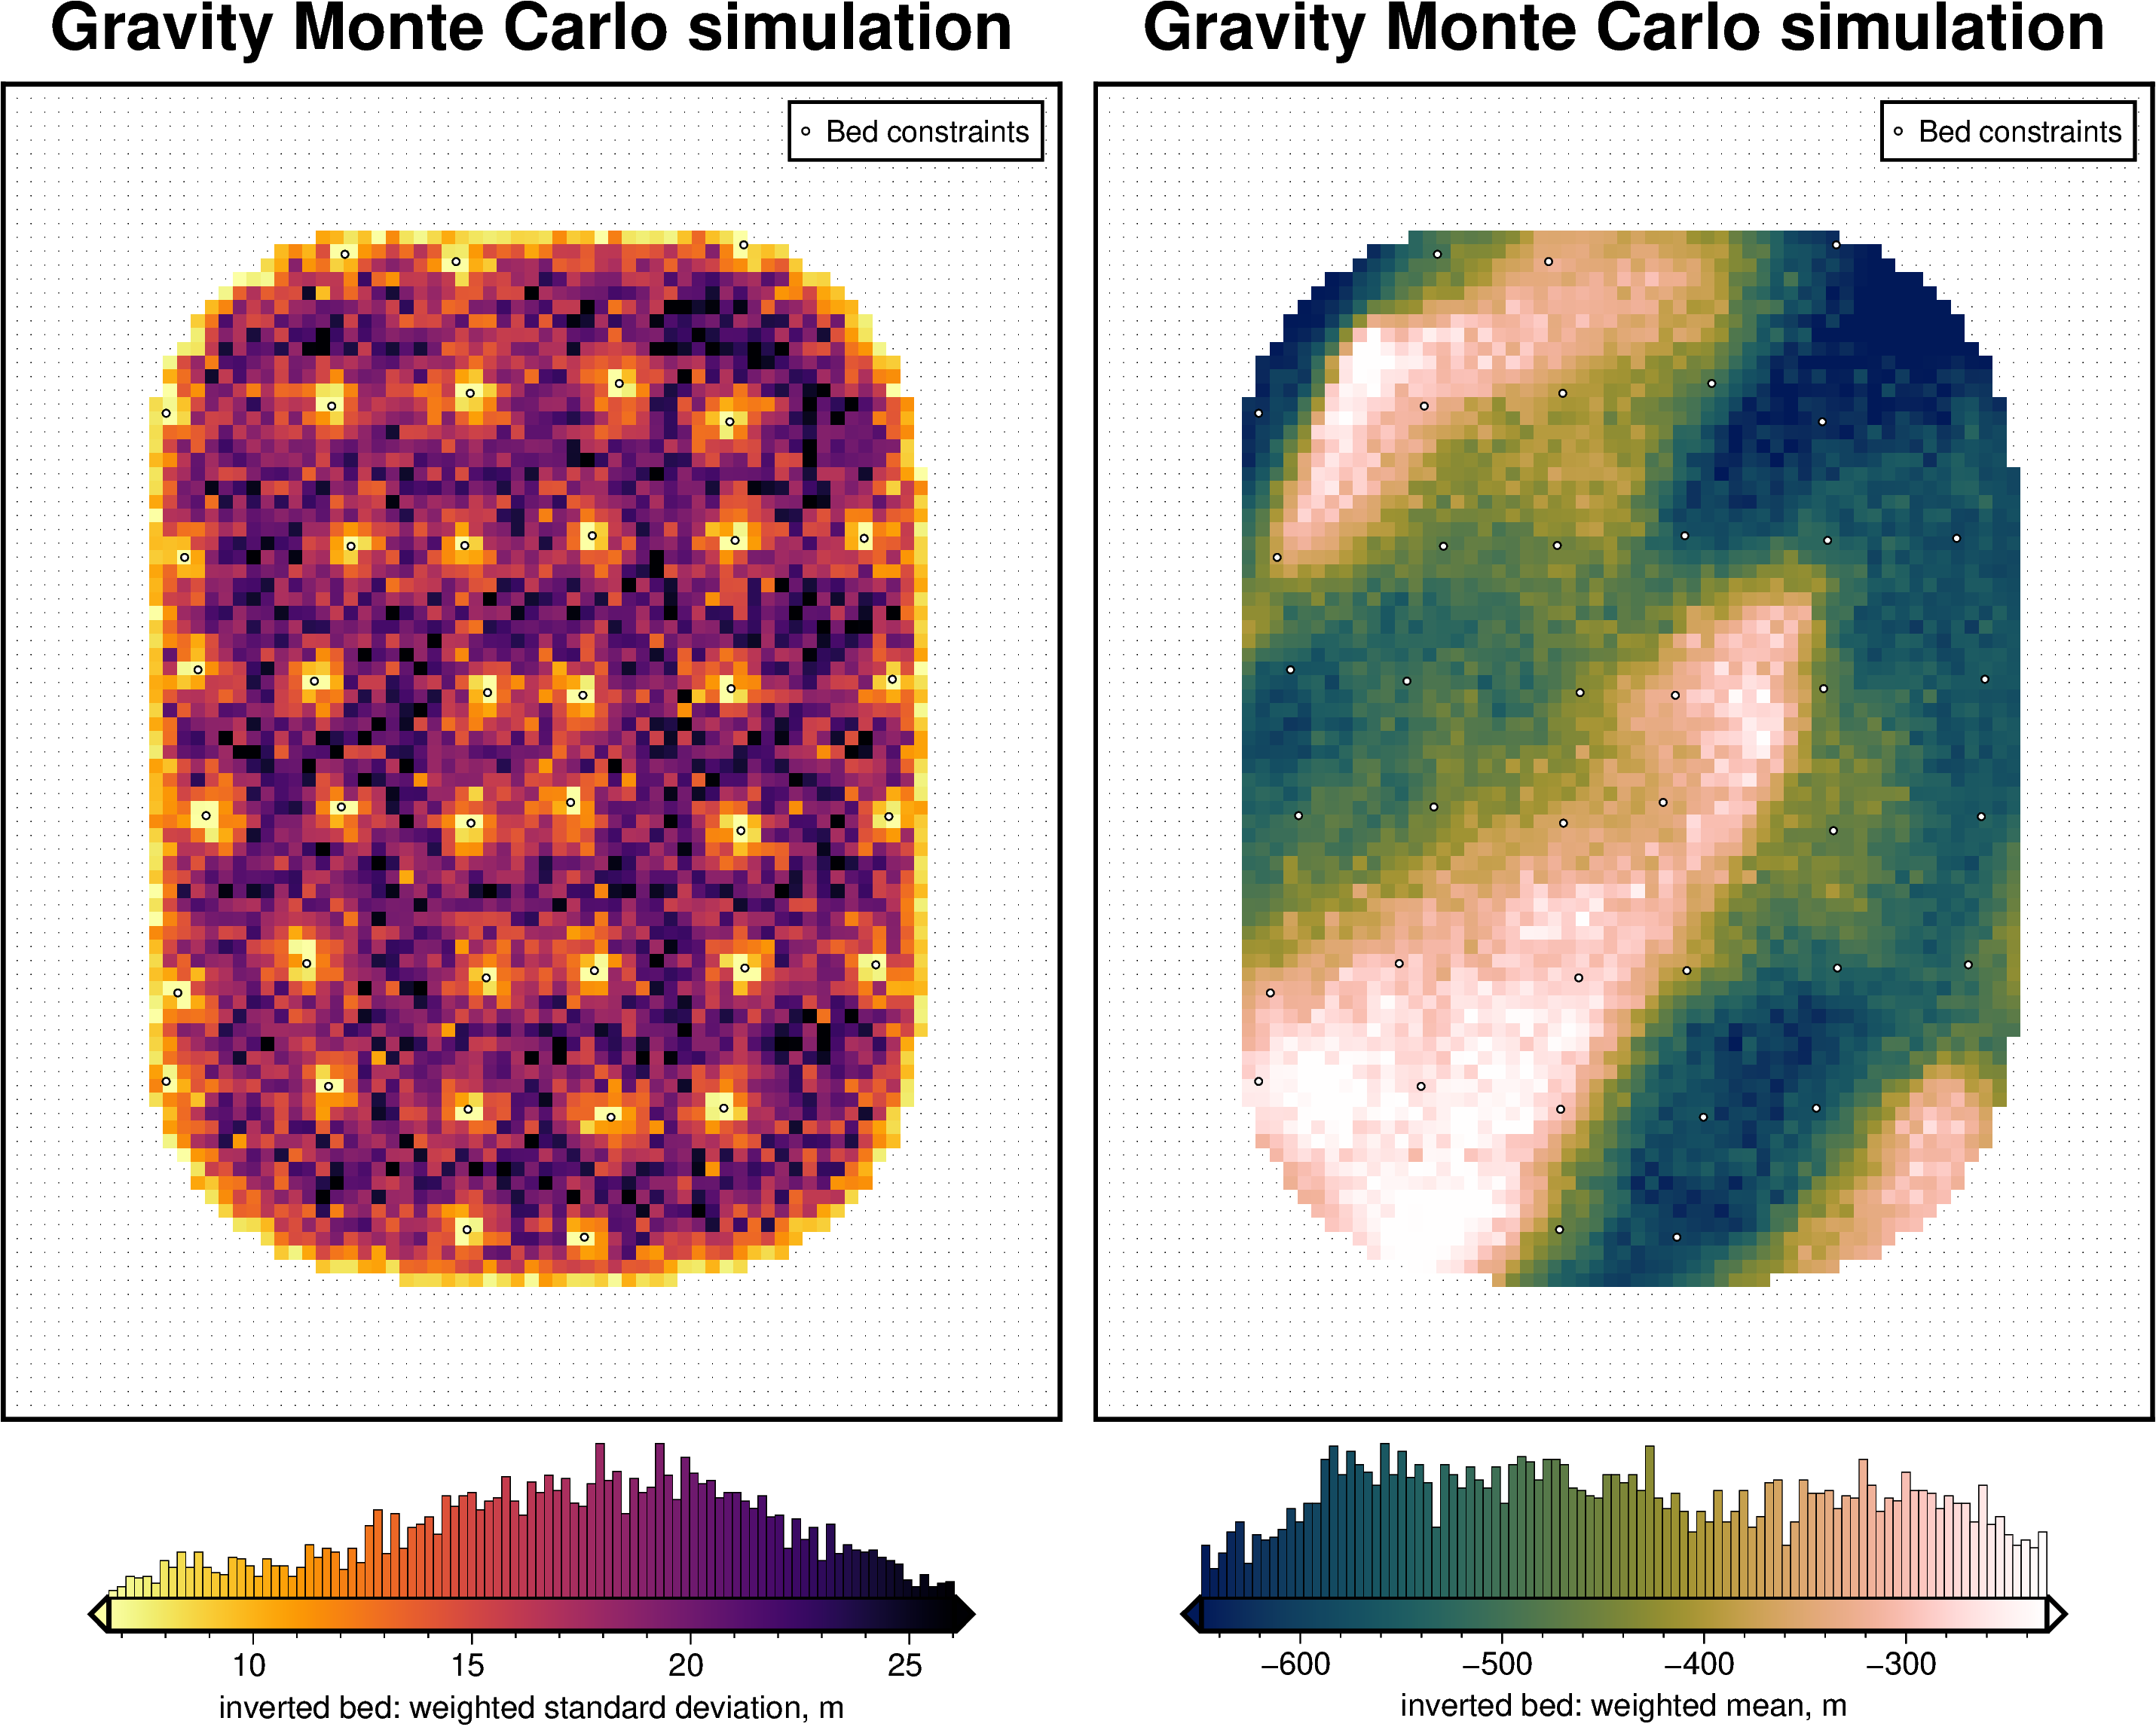

In [14]:
path = "../../synthetic_data/monte_carlo_results/"
prefix = "Ross_Sea_monte_carlo_gravity"
fname = path + prefix

full_surface_results = uncert.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,

    sample_grav=True,  # will recalculate regional field
    # sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    # sample_density_contrast=True,  # will recalculate bed gravity and regional field

    run_damping_CV = True,
    damping_CV_fname = path+"damping_CV_results/"+prefix,

    inversion_args=inversion_args,
    starting_args=starting_args,
    sampling="LHC",
    **kwargs,
)

params, values, grav_dfs, prism_dfs = full_surface_results

ds = uncert.merged_stats(
    full_surface_results,
    "topo",
    -1,
    plot=plot,
    # plot=False,
    mask="../../data/Ross_Sea_outline.shp",
    title="Gravity Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)

## Constraints

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

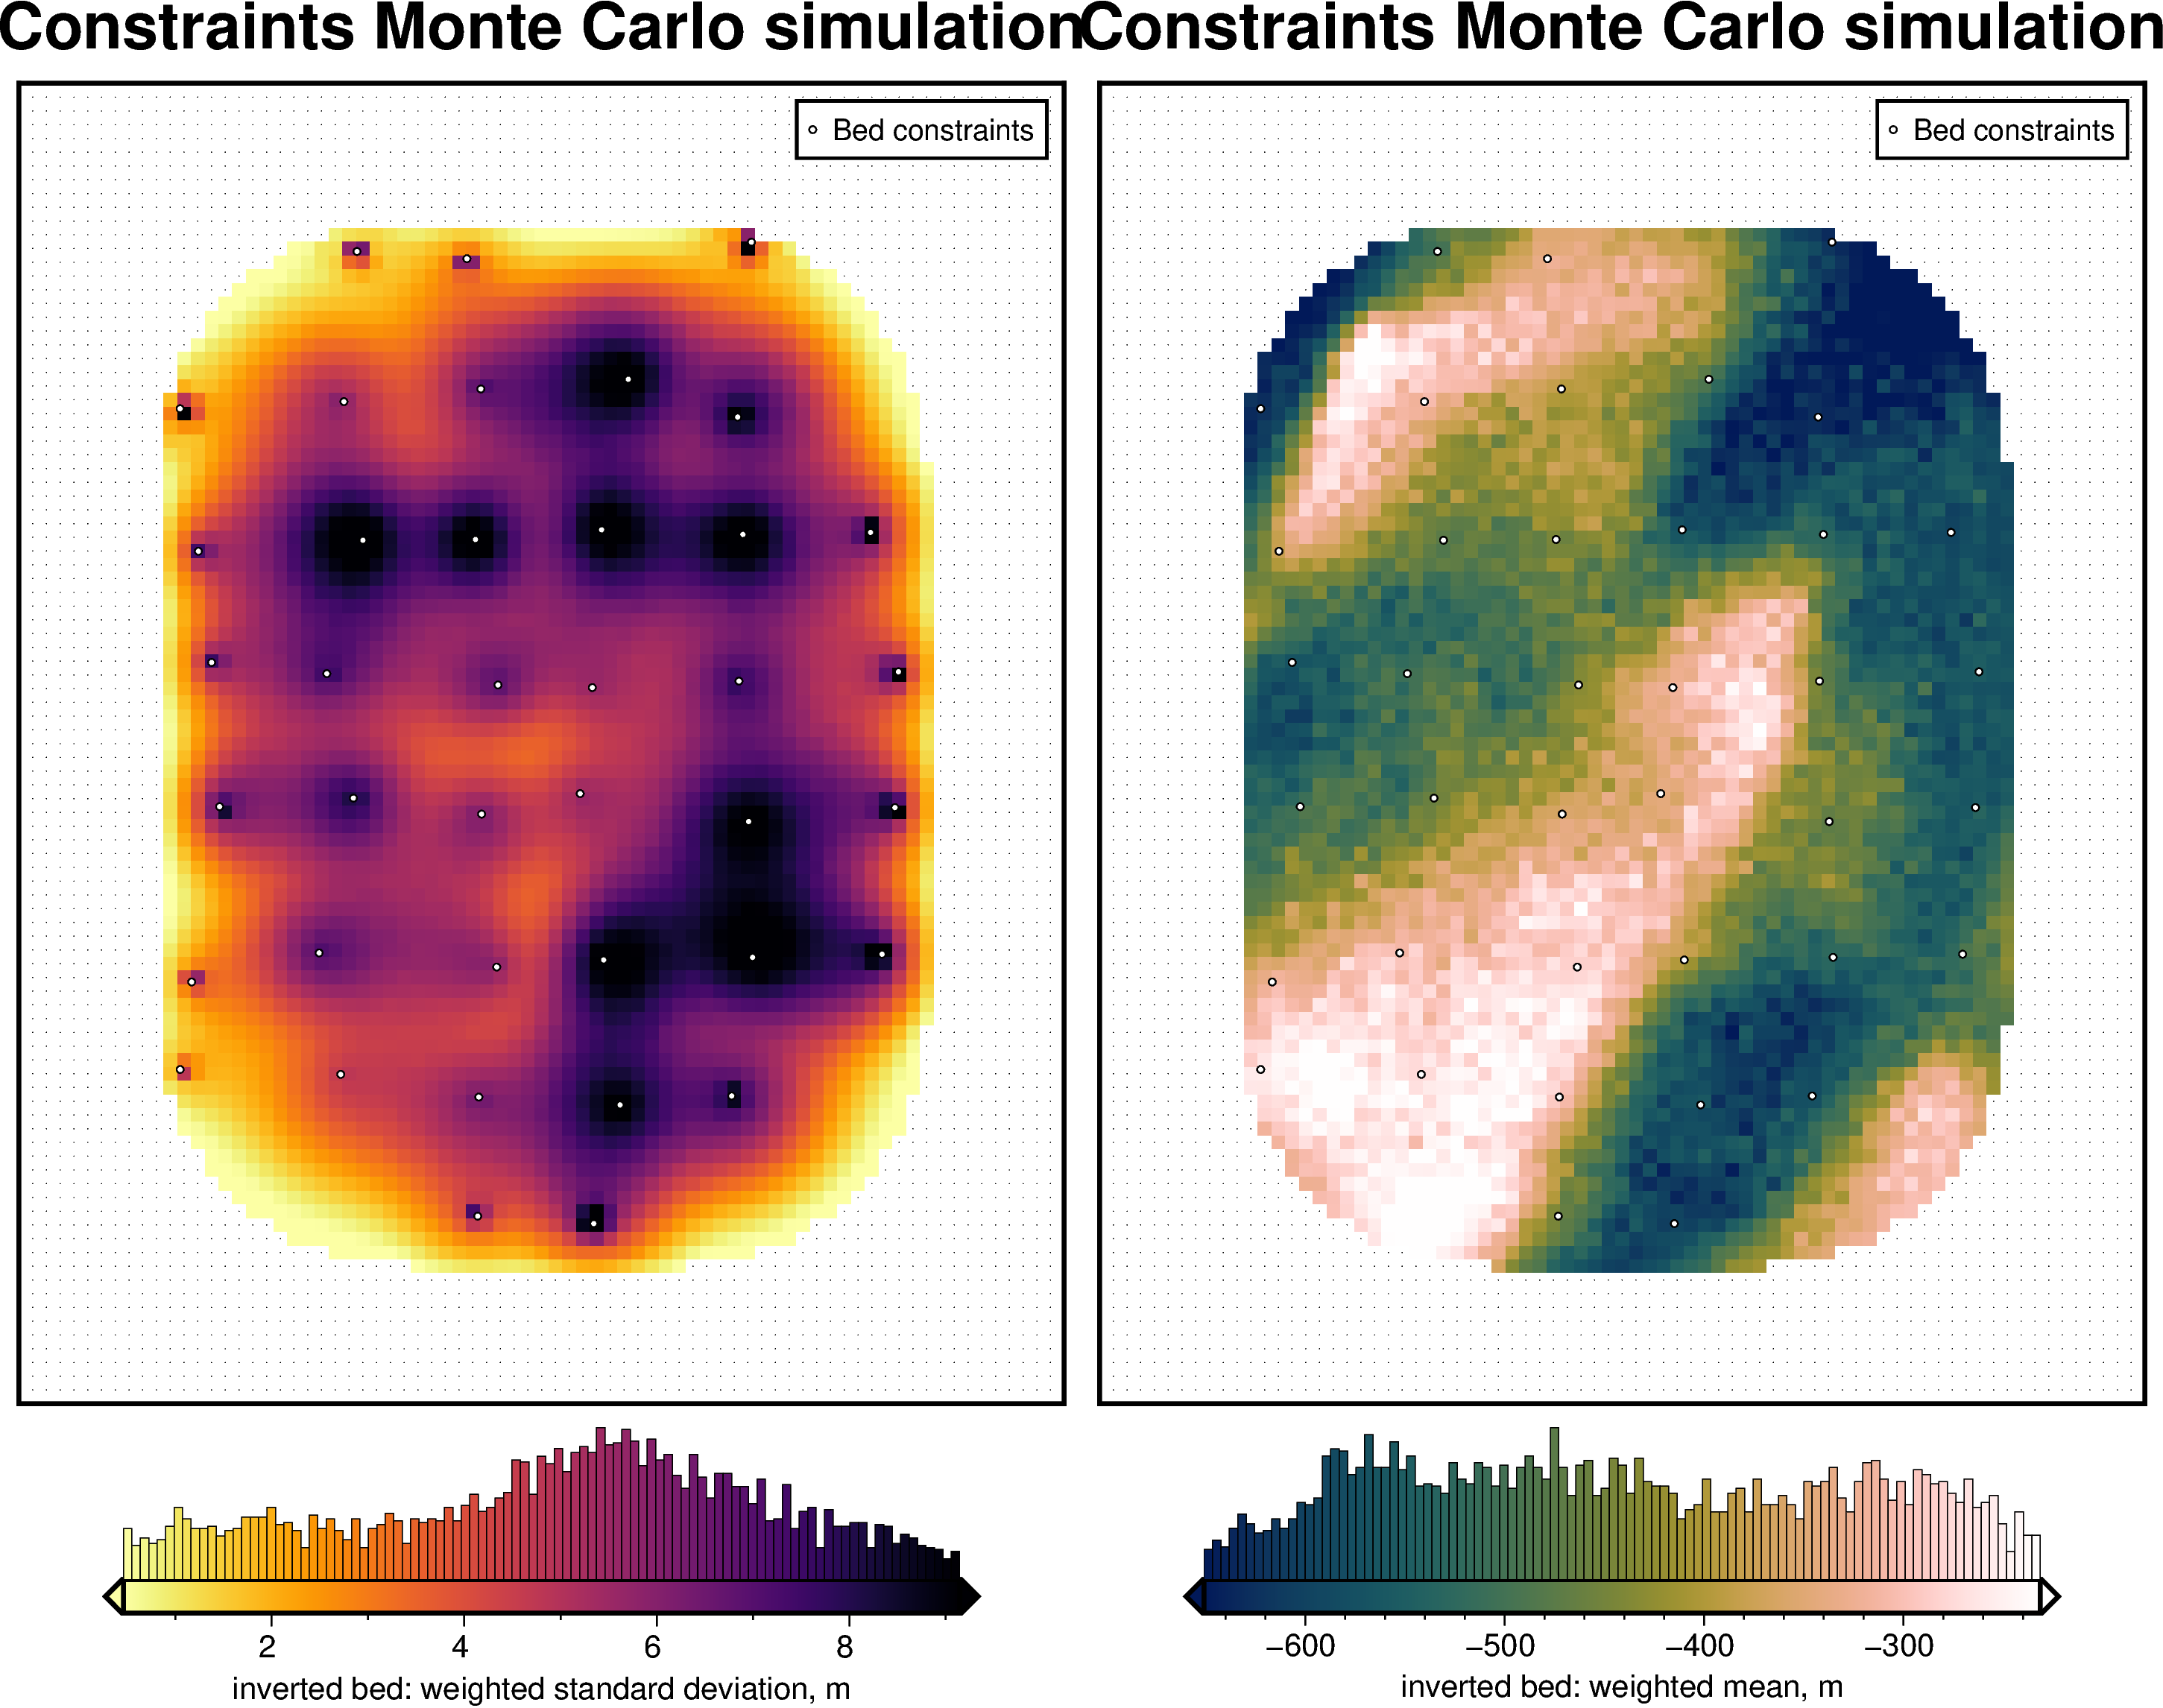

In [15]:
path = "../../synthetic_data/monte_carlo_results/"
prefix = "Ross_Sea_monte_carlo_constraints"
fname = path + prefix

full_surface_results = uncert.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,

    # sample_grav=True,  # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    # sample_density_contrast=True,  # will recalculate bed gravity and regional field

    run_damping_CV = True,
    damping_CV_fname = path+"damping_CV_results/"+prefix,

    inversion_args=inversion_args,
    starting_args=starting_args,
    sampling="LHC",
    **kwargs,
)

params, values, grav_dfs, prism_dfs = full_surface_results

ds = uncert.merged_stats(
    full_surface_results,
    "topo",
    -1,
    plot=plot,
    # plot=False,
    mask="../../data/Ross_Sea_outline.shp",
    title="Constraints Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)

## Densities

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

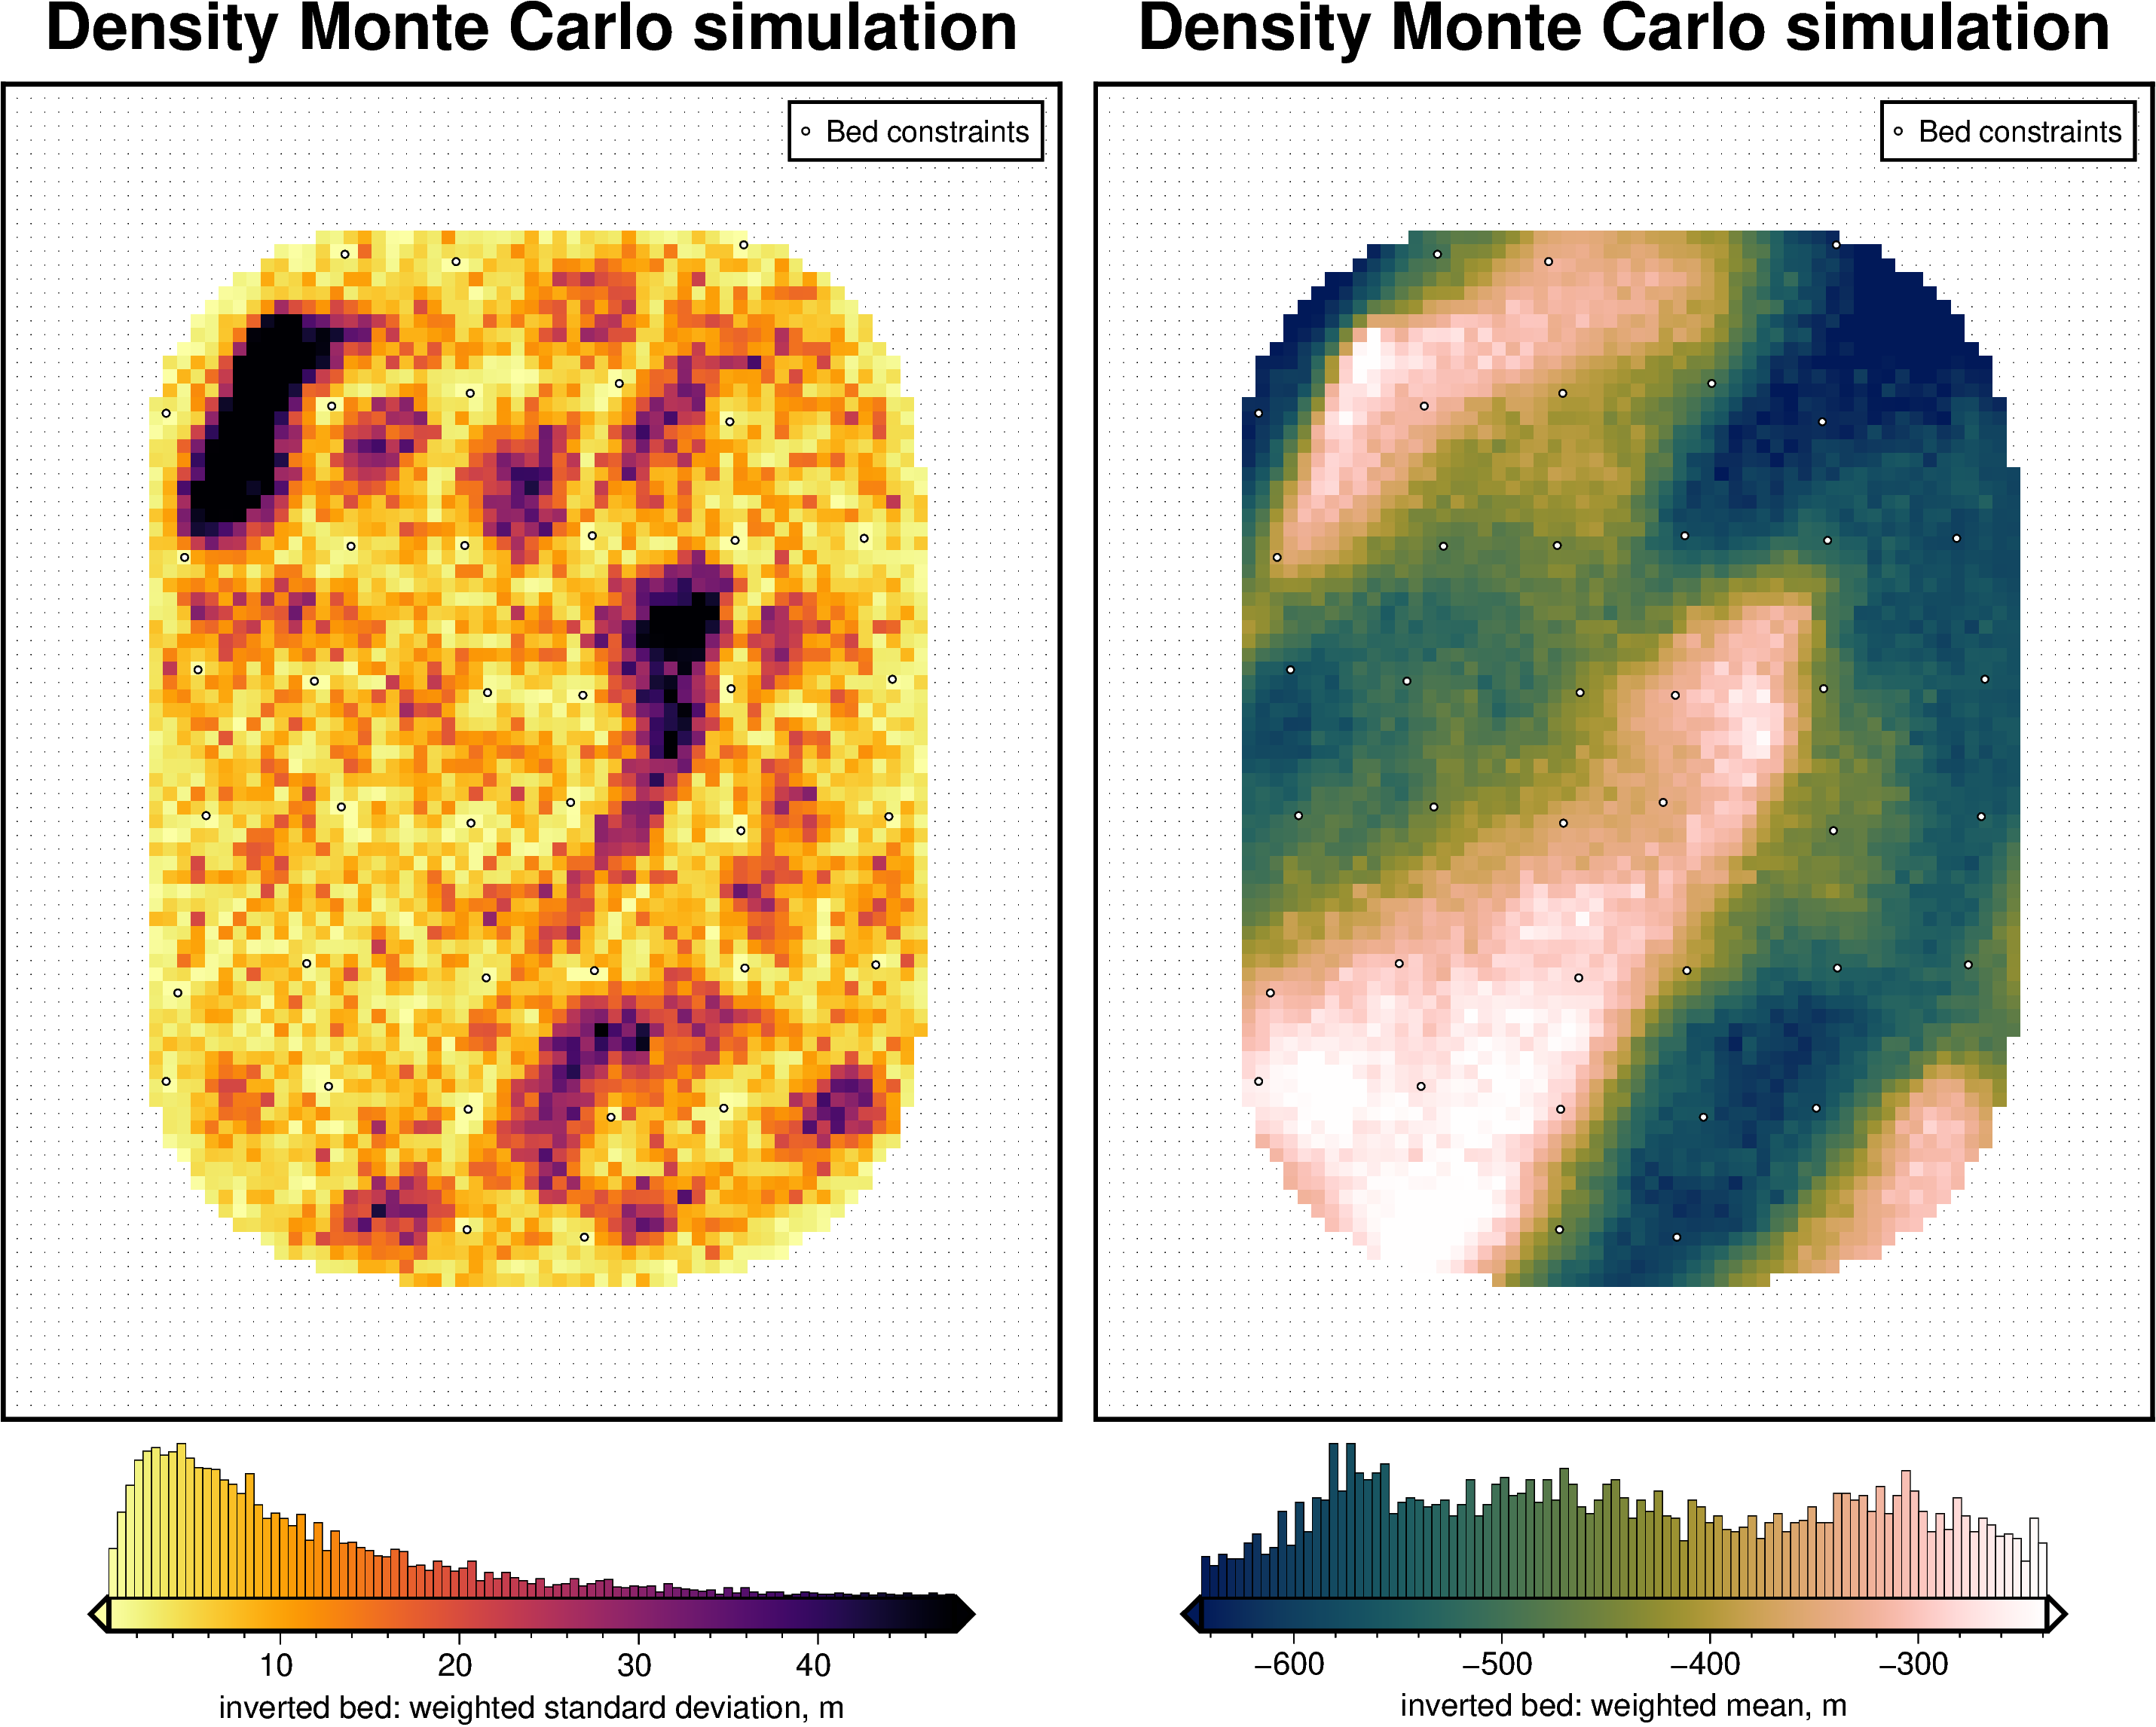

In [16]:
path = "../../synthetic_data/monte_carlo_results/"
prefix = "Ross_Sea_monte_carlo_densities"
fname = path + prefix

full_surface_results = uncert.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,

    # sample_grav=True,  # will recalculate regional field
    # sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    sample_density_contrast=True,  # will recalculate bed gravity and regional field

    run_damping_CV = True,
    damping_CV_fname = path+"damping_CV_results/"+prefix,

    inversion_args=inversion_args,
    starting_args=starting_args,
    sampling="LHC",
    **kwargs,
)

params, values, grav_dfs, prism_dfs = full_surface_results

ds = uncert.merged_stats(
    full_surface_results,
    "topo",
    -1,
    plot=plot,
    # plot=False,
    mask="../../data/Ross_Sea_outline.shp",
    title="Density Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)

# Combined plot

In [42]:
path = "../../synthetic_data/monte_carlo_results/"
prefixes = [
    "Ross_Sea_monte_carlo_gravity",
    "Ross_Sea_monte_carlo_constraints",
    "Ross_Sea_monte_carlo_densities",
    "Ross_Sea_monte_carlo_full",
    "Ross_Sea_monte_carlo_full",
]

MCstats = []
for i, j in enumerate(prefixes):
    result = uncert.monte_carlo_inversion_uncertainty_loop(
        fname=path + j,
        runs=runs,
        grav=df_anomalies,
        constraints=constraints,
    )
    ds = uncert.merged_stats(
        result,
        "topo",
        -1,
        plot=False,
        constraints=constraints,
        weight_by="constraints",
    )
    if i == 4:
        MCstats.append(ds.weighted_mean)
    else:
        MCstats.append(ds.weighted_stdev)

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

all 20 runs already complete, loading results from files.


0it [00:00, ?it/s]

In [43]:
# rename
names = [
    "stdev_gravity",
    "stdev_constraints",
    "stdev_densities",
    "stdev_full",
    "mean_z",
]
renamed = []
for i, j in enumerate(MCstats):
    renamed.append(j.rename(names[i]))

merged = xr.merge(renamed)
merged

<xarray.Dataset>
Dimensions:            (northing: 97, easting: 77)
Coordinates:
  * northing           (northing) float64 -1.84e+06 -1.835e+06 ... -1.36e+06
  * easting            (easting) float64 -8e+04 -7.5e+04 ... 2.95e+05 3e+05
Data variables:
    stdev_gravity      (northing, easting) float64 1.137e-13 1.137e-13 ... 0.0
    stdev_constraints  (northing, easting) float64 3.411e-13 ... 1.137e-13
    stdev_densities    (northing, easting) float64 3.411e-13 ... 1.137e-13
    stdev_full         (northing, easting) float64 0.0 1.137e-13 ... 1.137e-13
    mean_z             (northing, easting) float64 -834.3 -761.0 ... -968.7

In [44]:
enc = {x: {"compressor": zarr.Blosc()} for x in merged}
merged.to_zarr(
    "../../synthetic_data/monte_carlo_results/Ross_Sea_Monte_Carlo_inversion_results.zarr",
    encoding=enc,
    mode="w",
)

In [45]:
MCstats = xr.open_zarr(
    "../../synthetic_data/monte_carlo_results/Ross_Sea_Monte_Carlo_inversion_results.zarr",
)

MCstats

<xarray.Dataset>
Dimensions:            (easting: 77, northing: 97)
Coordinates:
  * easting            (easting) float64 -8e+04 -7.5e+04 ... 2.95e+05 3e+05
  * northing           (northing) float64 -1.84e+06 -1.835e+06 ... -1.36e+06
Data variables:
    mean_z             (northing, easting) float64 dask.array<chunksize=(97, 77), meta=np.ndarray>
    stdev_constraints  (northing, easting) float64 dask.array<chunksize=(97, 77), meta=np.ndarray>
    stdev_densities    (northing, easting) float64 dask.array<chunksize=(97, 77), meta=np.ndarray>
    stdev_full         (northing, easting) float64 dask.array<chunksize=(97, 77), meta=np.ndarray>
    stdev_gravity      (northing, easting) float64 dask.array<chunksize=(97, 77), meta=np.ndarray>

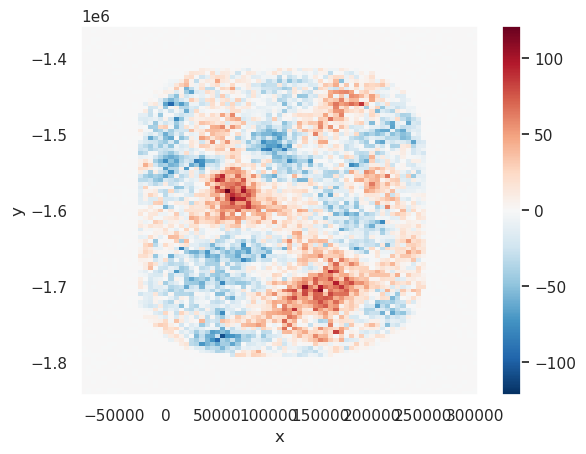

In [47]:
(bed-MCstats.mean_z).plot()

mapproject [WARNING]: For a UTM or TM projection, your region -40000.0/260000.0/-1800000.0/-1400000.0 is too large to be in degrees and thus assumed to be in meters


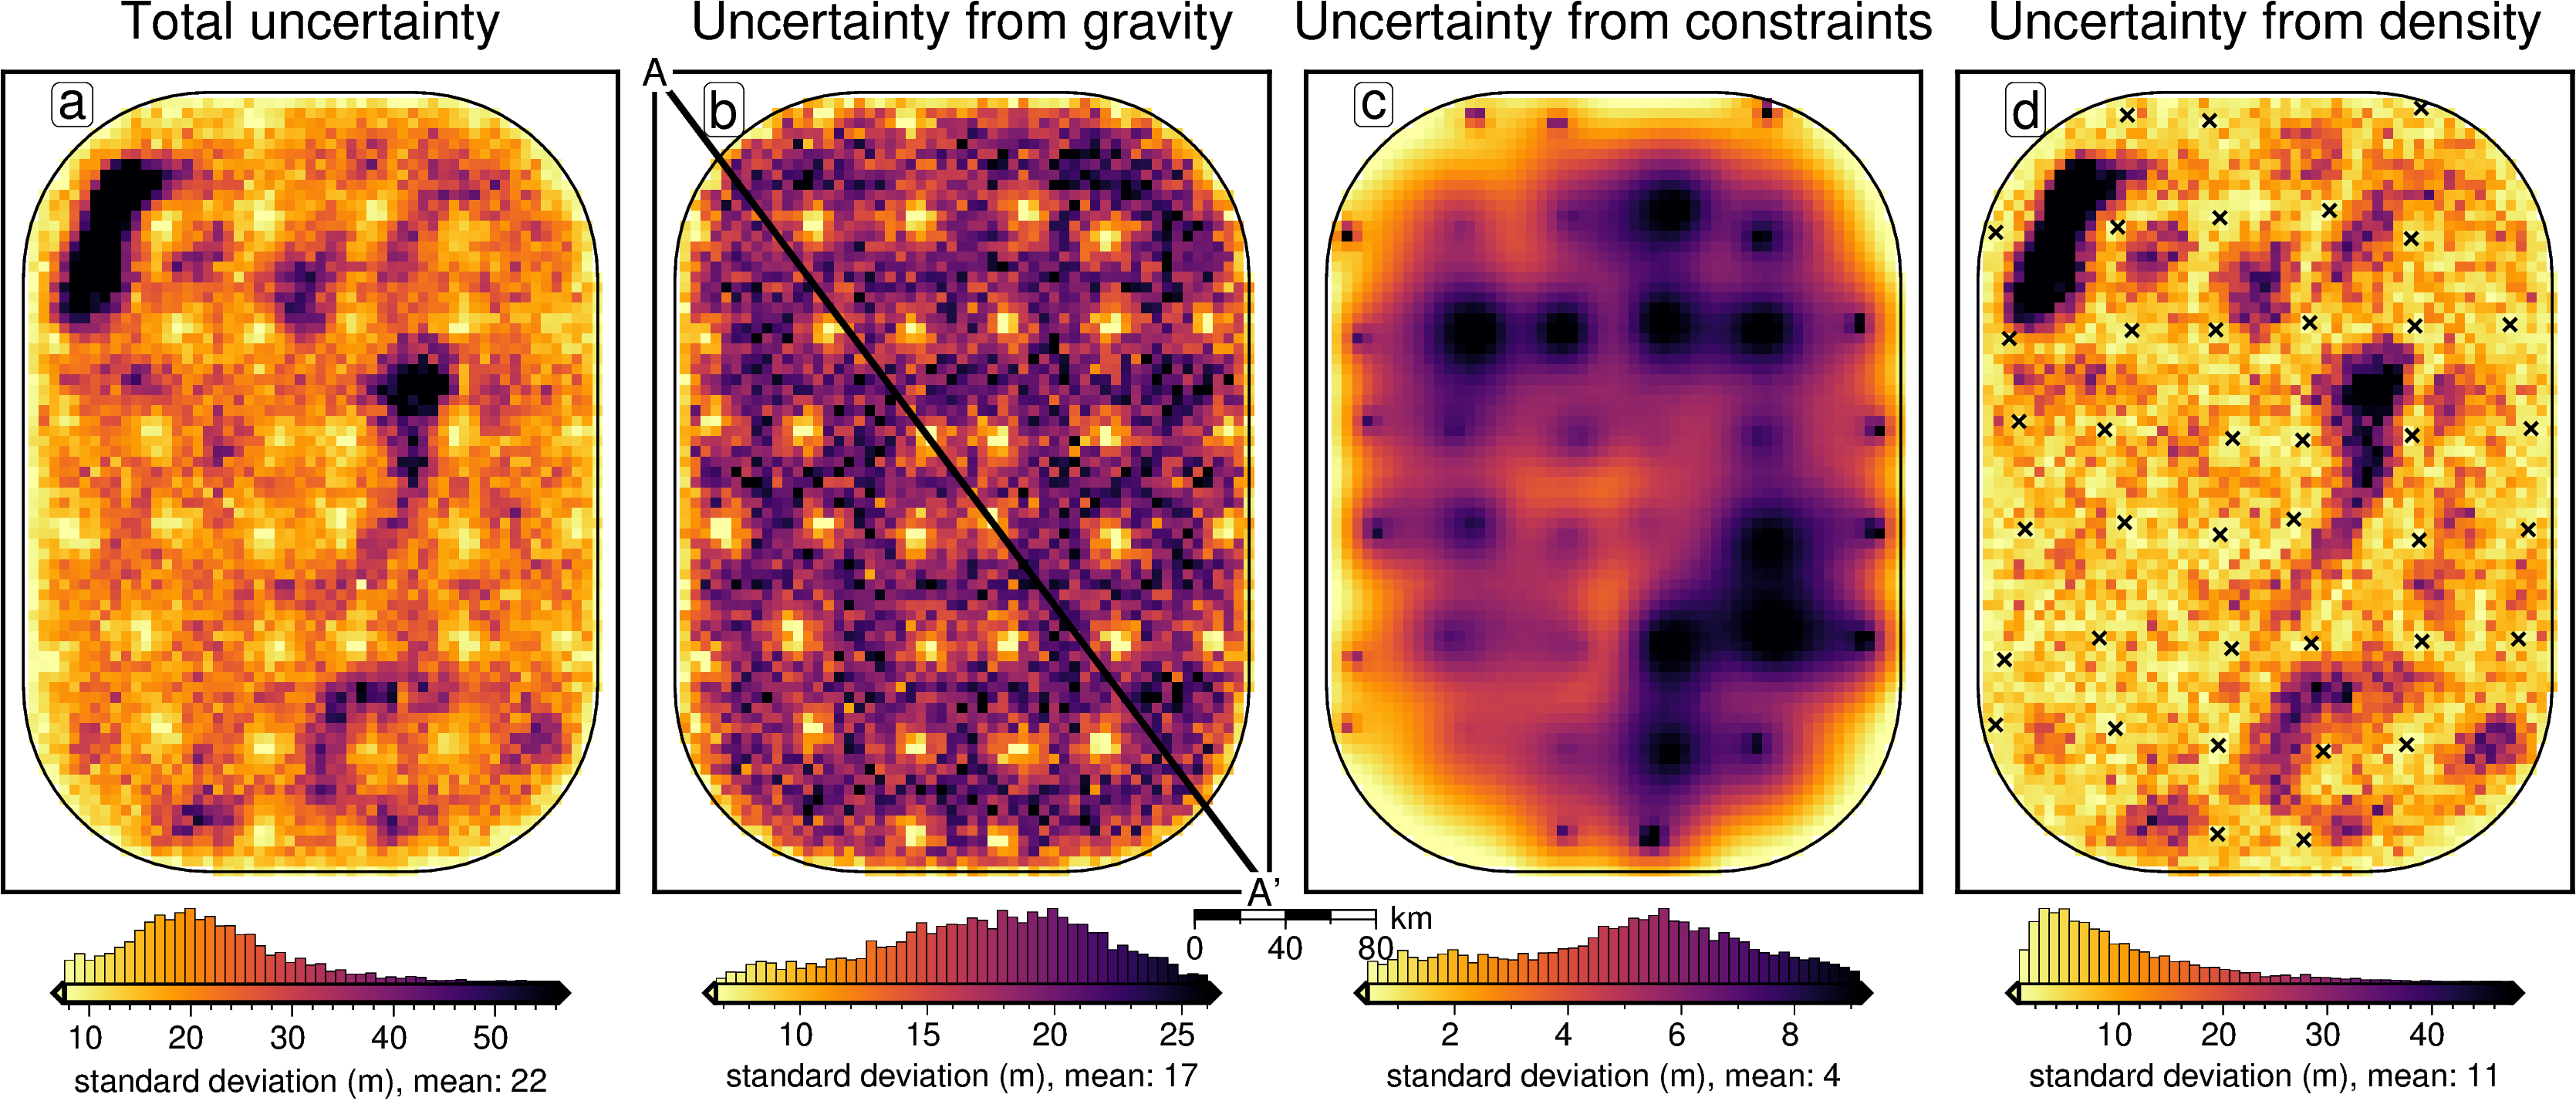

In [57]:
import string 

titles = [
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
]
grids = [
    MCstats.stdev_full,
    MCstats.stdev_gravity,
    MCstats.stdev_constraints,
    MCstats.stdev_densities,
]

region = inversion_region

fig_height = 9
for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
    else:
        fig = fig
        origin_shift = "xshift"

    cmap = ("inferno",)
    reverse_cpt = True
    g = utils.mask_from_shp(
        shapefile="../../data/Ross_Sea_outline.shp",
        xr_grid=g,
        masked=True,
        invert=False,
    )

    lims = utils.get_min_max(
        g,
        robust=True,
        shapefile="../../data/Ross_Sea_outline.shp",
    )
    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        region=region,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap=cmap,
        cpt_lims=lims,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        reverse_cpt=reverse_cpt,
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
    )

    if i == 3:
        fig.plot(
            x=constraints[constraints.inside].easting,
            y=constraints[constraints.inside].northing,
            style="x.2c",
            pen="1p,black",
        )
    fig.plot(
        "../../data/Ross_Sea_outline.shp",
        pen="0.8p,black",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 1:
        # plot profile location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
    if i == 2:
        info = utils.set_proj(
            region,
            fig_height=10,
        )
        maps.add_scalebar(fig, region, info[1], position="n-.03/-.03")
        # maps.add_north_arrow(fig, region, info[1], position="n.45/.07")
fig.show()

### plot profile

In [53]:
data_dict = profile.make_data_dict(
    names=titles,
    grids=grids,
    colors=["black", "blue", "red", "cyan",],
)

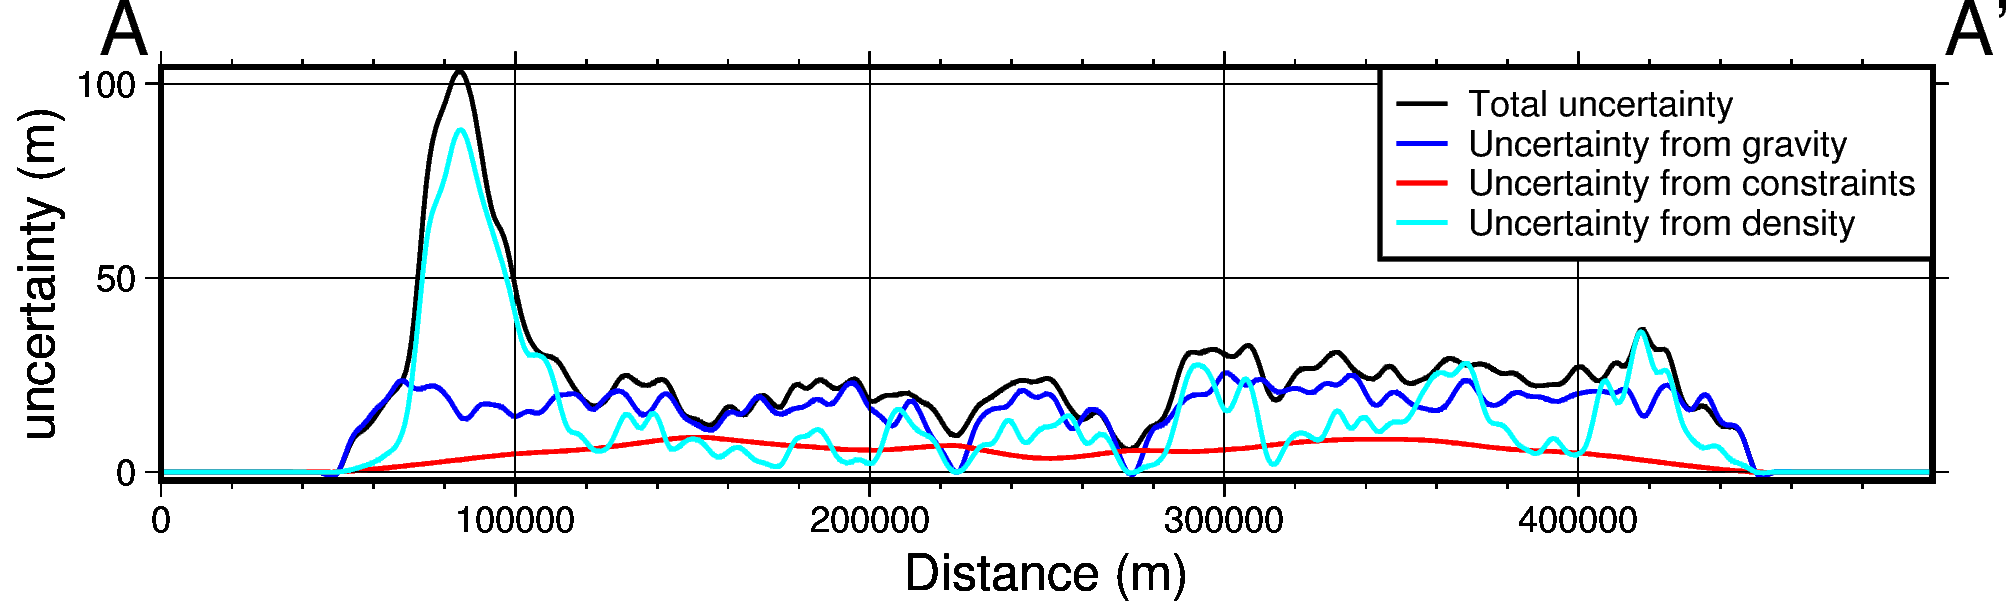

In [54]:
fig, df_data = profile.plot_data(
    "points",
    start = [inversion_region[0], inversion_region[3]],
    stop = [inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    
    data_dict=data_dict,
    data_legend_loc="jTR+jTR",#+o0c/.4c",
    data_legend_box="+gwhite+c0c+p1p",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,

    start_label="A",
    end_label="A' ",
)
fig.show()

In [55]:
# get grid of min dists to nearest constraints
min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
)
df_data = profile.sample_grids(df_data, min_dist, interpolation="b",name="min_dist")

# df_data.describe()

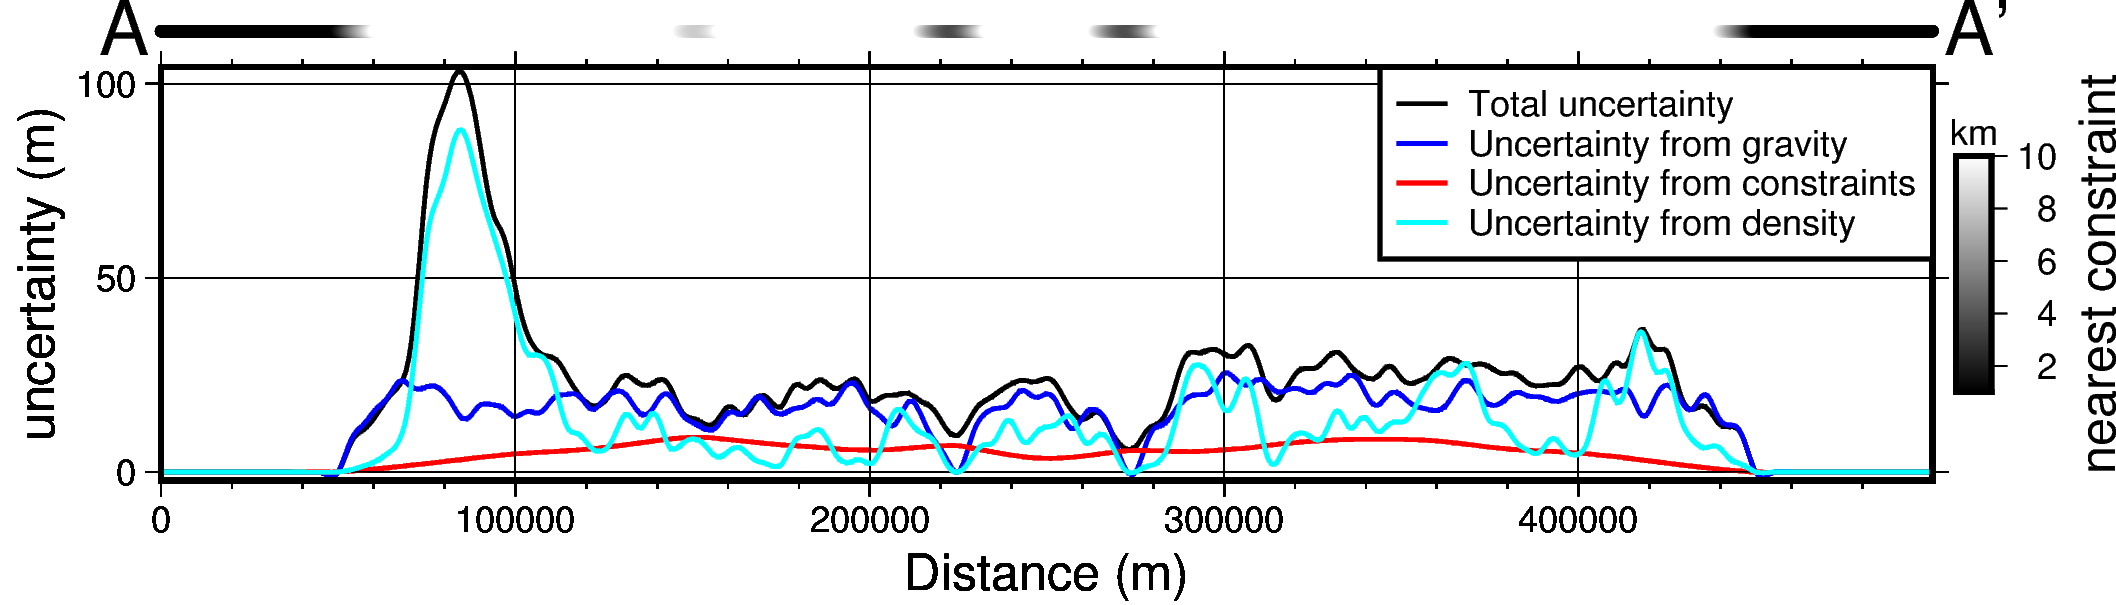

In [56]:
data_max=np.max(df_data[["0","1","2"]].values)*1.1

# series = utils.get_min_max(df_data.min_dist, robust=False)
series = [1e3,10e3]
pygmt.makecpt(
    cmap="gray",
    series= series,
    background=True,
)
fig.plot(
    x=df_data.dist,
    y=np.ones_like(df_data.dist)*data_max,
    style="c0.1c",
    fill=df_data.min_dist,
    cmap=True,
    no_clip=True,
)
fig.colorbar(
    cmap=True,
    position="jMR+w2c/.3c+jML+v+o0.2c/0c",
    frame=[f"xa+lnearest constraint", "y+lkm"],
    scale=0.001,
)

fig.show()